# Initialization

Interactive use of the `scqubits` library from a jupyter notebook starts with importing the `scqubits` library. Additional imports, e.g.,  `numpy` and the QuTiP library are optional.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import scqubits as qubit
import scqubits.utils.plotting as plot


import numpy as np
import qutip as qt

C:\Users\drjen\Miniconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Interfacing with qutip

## Example: two Cooper pair boxes coupled to one resonator mode
$\displaystyle H=\sum_{\alpha=1,2}\sum_{j} E_j^{(\alpha)}|\alpha j\rangle\langle \alpha j| + \omega_r a^\dagger a + \sum_{\alpha=1,2}\sum_{j,k}g^{(\alpha)}_{jk} |\alpha j\rangle \langle \alpha k|(a+a^\dagger)$

### Define Hilbert space components, Hilbert space tuple, and system operators

In [2]:
# Set up the components / subspaces of our Hilbert space
# Objects may be taken from scqubits; for resonators or other
# elements not covered, the class GenericQSys is provided in
# the qubitwrapper module

CPB1 = qubit.Transmon(
    EJ = 40.0,
    EC = 0.2,
    ng = 0.3,
    ncut = 40,
    truncated_dim = 3     # after diagonalization, we will keep 3 levels
)

CPB2 = qubit.Transmon(
    EJ = 3.0,
    EC = 1.0,
    ng = 0.0,
    ncut = 10,
    truncated_dim = 4
)

resonator = qubit.Oscillator(
    omega = 6.0,
    truncated_dim=4  # up to 3 photons (0,1,2,3)
)


# Form a list of all components making up the Hilbert space.
hilbertspc = qubit.HilbertSpace([CPB1, CPB2, resonator])

In [3]:
# Get resonator Hamiltonian (full product Hilbert space)
hres = hilbertspc.diag_hamiltonian(resonator)

# Get diagonalized CPB1 Hamiltonian as full-system operator via tensor product with identities.
h1 = hilbertspc.diag_hamiltonian(CPB1)

# Get diagonalized CPB2 Hamiltonian as full-system operator via tensor product with identities.
h2 = hilbertspc.diag_hamiltonian(CPB2)

### Additional system parameters

In [7]:
g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

dim1 = CPB1.truncated_dim
dim2 = CPB2.truncated_dim

_, evecs1 = CPB1.eigensys(dim1)
_, evecs2 = CPB2.eigensys(dim2)
gmat1 = g1 * qubit.get_matrixelement_table(CPB1.n_operator(), evecs1)   # coupling constants for CPB1
gmat2 = g2 * qubit.get_matrixelement_table(CPB2.n_operator(), evecs2)   # and for CPB2

In [8]:
hbd = hilbertspc.hubbard_operator

a = hilbertspc.annihilate(resonator)

hamiltonian0 = h1 + h2 + hres

vcpb1 = sum([gmat1[j][k] * hbd(j,k,CPB1) for j in range(dim1) for k in range(dim1)])
vcpb2 = sum([gmat2[j][k] * hbd(j,k,CPB2) for j in range(dim2) for k in range(dim2)])

hamiltonian1 = (vcpb1 + vcpb2) * (a + a.dag())

hamiltonian = hamiltonian0 + hamiltonian1

In [9]:
esys = hamiltonian.eigenstates()

In [10]:
# Example: spectrum when varying the Josephson energy of CPB1 via a flux
# Set up Hamiltonian:

ham0 = h2 + hres

vcpb2 = sum([gmat2[j][k] * hbd(j,k,CPB2) for j in range(dim2) for k in range(dim2)])

def hamiltonian(flux):
    CPB1.EJ = 40.0 * np.cos(np.pi*flux)
    h1 = hilbertspc.diag_hamiltonian(CPB1)
    vcpb1 = sum([gmat1[j][k] * hbd(j,k,CPB1) for j in range(dim1) for k in range(dim1)])
    
    return (h1 + ham0 + (vcpb1 + vcpb2) * (a + a.dag()))

In [11]:
flux_list = np.linspace(-0.1, 0.6, 100)
specdata = hilbertspc.get_spectrum_vs_paramvals(hamiltonian, flux_list, evals_count=15, get_eigenstates=True)


[====================] 100% Done.


In [12]:
specdata.energy_table[2]

array([-35.61671109, -30.87536252, -29.93935539, -29.62839549,
       -27.95521996, -24.89469034, -23.95779031, -23.64010506,
       -23.21389138, -22.27788515, -21.97003287, -20.49827277,
       -18.91372364, -18.6059474 , -17.97609201])

In [13]:
absorptiondata = hilbertspc.absorption_spectrum(specdata, ((CPB1, 0), (CPB2, 0), (resonator, 0)), initial_as_bare=True)


[====================] 100% Done.


In [14]:
absorptiondata.energy_table[5]

array([ 0.        ,  4.74134965,  5.67735584,  5.98885753,  7.72433769,
       10.72256393, 11.65946188, 11.97769128, 12.46566932, 13.40167469,
       13.71033934, 15.24395056, 16.7040735 , 17.01076372, 17.64170233])

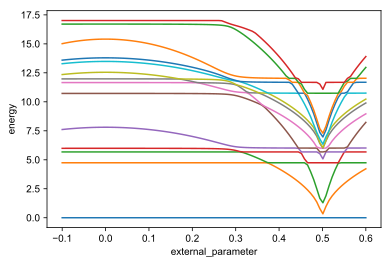

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x207792643c8>)

In [15]:
absorptiondata.plot_evals_vs_paramvals()